In [1]:
import numpy as np
import pandas as pd
import math
import scipy.io
import random
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
#loading regression methods
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression as lor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression as lr
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as qda
from sklearn.naive_bayes import GaussianNB as gnb
from sklearn.tree import DecisionTreeClassifier as dt
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.svm import SVC as svc
from sklearn.svm import NuSVC as nusvc
from sklearn.svm import LinearSVC as lsvc
from sklearn.svm import LinearSVR as lsvr
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
import seaborn as sns

In [2]:
geno = pd.read_csv('geno100.csv')
geno =  geno.drop('ChemoResponse',axis = 1)
meta = pd.read_csv("meta_processed.csv")
meta["DRFS_Year"] = meta["DRFS_Year"].fillna("unknown")

In [3]:
meta

,Age,ER_Status,PR_Status,HER2_Status,Grade,T_Stage,N_Stage,PAM50_Class,DRFS_Event,DRFS_Year,ChemoEncoding
0,44.0,positive,positive,negative,2.0,T3,N0,unknown,unknown,unknown,0
1,43.0,positive,positive,negative,unknown,T4,N1,unknown,unknown,unknown,0
2,56.0,negative,negative,negative,3,T4,N3,unknown,unknown,cat1,0
3,41.0,positive,negative,negative,2,T2,N1,unknown,unknown,cat3,0
4,39.0,positive,positive,negative,3.0,T2,N1,unknown,unknown,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...
1166,46.0,negative,negative,positive,3.0,T3,unknown,unknown,unknown,unknown,1
1167,62.0,positive,positive,negative,3,T4,N1,unknown,unknown,cat1,0
1168,44.0,positive,negative,negative,2.0,T2,unknown,unknown,unknown,unknown,0
1169,38.0,positive,positive,negative,3,T4,N1,unknown,unknown,cat3,0


In [4]:
def train_test_dev_split(X_concat,meta):
    if(type(X_concat) != type(pd.DataFrame())):
        X_concat = pd.DataFrame(X_concat)
    pos_index = meta.index[meta['ChemoEncoding'] == 1].values
    neg_index = meta.index[meta['ChemoEncoding'] == 0].values
    
    n_pos, n_neg = pos_index.shape[0], neg_index.shape[0]

    rng = np.random.default_rng(37)
    rng.shuffle(pos_index)
    rng.shuffle(neg_index)


    train_idx_pos, train_idx_neg = int(n_pos*0.8), int(n_neg* 0.8)
    test_idx_pos, test_idx_neg = train_idx_pos + int(n_pos*0.1), train_idx_neg + int(n_neg*0.1)
    dev_idx_pos, dev_idx_neg = test_idx_pos, test_idx_neg


    train_idx = np.r_[pos_index[:train_idx_pos], neg_index[:train_idx_neg] ]
    test_idx = np.r_[pos_index[train_idx_pos:test_idx_pos], neg_index[train_idx_neg:test_idx_neg]]
    dev_idx = np.r_[pos_index[test_idx_pos:], neg_index[test_idx_neg:]]
    print(f'train_idx:{train_idx.shape[0]}')
    print(f'test_idx:{test_idx.shape[0]}')
    print(f'dec_idx:{dev_idx.shape[0]}')
    
    X_train, y_train = X_concat.iloc[train_idx,:], meta.iloc[train_idx,:]['ChemoEncoding']
    X_test, y_test = X_concat.iloc[test_idx,:], meta.iloc[test_idx,:]['ChemoEncoding']
    X_dev, y_dev = X_concat.iloc[dev_idx,:], meta.iloc[dev_idx,:]['ChemoEncoding']
    
    return (X_train,y_train), (X_test,y_test), (X_dev,y_dev)

In [5]:
def get_geno_concat(geno, meta):
    X = meta.drop('ChemoEncoding', axis=1)
    X_new = pd.concat([X, geno],axis= 1)
    contious_cols = X_new[list(geno.columns) + ['Age']]
    X_categorical = X_new.drop(list(geno.columns) + ['Age'], axis=1)
    # apply one-hot encoding to the categorical features
    X_cate_OH = pd.get_dummies(X_categorical)
    X_new_OH = pd.concat([contious_cols,  X_cate_OH], axis=1)
    
    return X_new_OH

### Train Test split

In [6]:
# X and Y train are for traning 
# X and Y test are for picking algothrims and tuning paramters 
# X and Y dev are only used when we pick our final model and check for performances
X_concat = get_geno_concat(geno, meta)
train_set, test_set, dev_set = train_test_dev_split(X_concat, meta)
X_train, y_train = train_set
X_test, y_test = test_set
X_dev, y_dev = dev_set

train_idx:936
test_idx:116
dec_idx:119


In [7]:
X_train.shape

(936, 136)

### View distribution

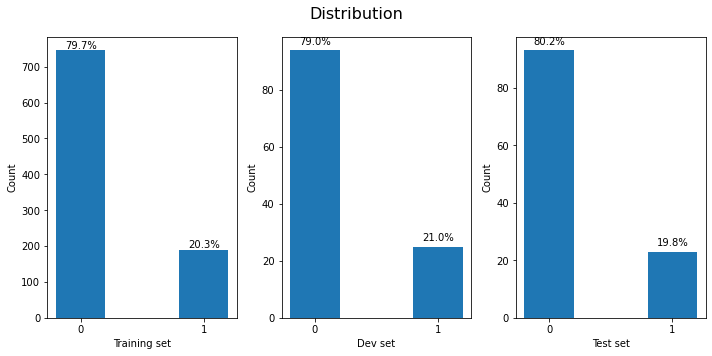

In [8]:
# Count number of 0s and 1s in each set
train_counts = np.bincount(y_train)
dev_counts = np.bincount(y_dev)
test_counts = np.bincount(y_test)

# Compute percentages
train_percentages = train_counts / len(y_train) * 100
dev_percentages = dev_counts / len(y_dev) * 100
test_percentages = test_counts / len(y_test) * 100

# Plot bar chart with percentages
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].bar([0, 1], train_counts, width=0.4, label='Counts')
ax[1].bar([0, 1], dev_counts, width=0.4, label='Counts')
ax[2].bar([0, 1], test_counts, width=0.4, label='Counts')
ax[0].text(0, train_counts[0] + 5, f"{train_percentages[0]:.1f}%", ha='center')
ax[0].text(1, train_counts[1] + 5, f"{train_percentages[1]:.1f}%", ha='center')
ax[1].text(0, dev_counts[0] + 2, f"{dev_percentages[0]:.1f}%", ha='center')
ax[1].text(1, dev_counts[1] + 2, f"{dev_percentages[1]:.1f}%", ha='center')
ax[2].text(0, test_counts[0] + 2, f"{test_percentages[0]:.1f}%", ha='center')
ax[2].text(1, test_counts[1] + 2, f"{test_percentages[1]:.1f}%", ha='center')
ax[0].set_xticks([0, 1])
ax[1].set_xticks([0, 1])
ax[2].set_xticks([0, 1])
ax[0].set_xticklabels(['0', '1'])
ax[1].set_xticklabels(['0', '1'])
ax[2].set_xticklabels(['0', '1'])
ax[0].set_xlabel('Training set')
ax[1].set_xlabel('Dev set')
ax[2].set_xlabel('Test set')
ax[0].set_ylabel('Count')
ax[1].set_ylabel('Count')
ax[2].set_ylabel('Count')
fig.suptitle('Distribution', fontsize=16)
plt.tight_layout()
plt.show()


### Apply models 

In [9]:
model=[lda(),qda(),gnb(),rf(),svc(),lsvc(),knn(),lor(),xgb.XGBClassifier(max_depth=5, n_estimators=100, random_state=17),AdaBoostClassifier(n_estimators=100, random_state=17)]
print('a','model')
for i in model:
    clf=i.fit(X_train,y_train)
    a=accuracy_score(y_test, clf.predict(X_test))
    print(a,i)

a model
0.7931034482758621 LinearDiscriminantAnalysis()
0.646551724137931 QuadraticDiscriminantAnalysis()
0.6551724137931034 GaussianNB()
0.8362068965517241 RandomForestClassifier()
0.8017241379310345 SVC()
0.8189655172413793 LinearSVC()
0.8189655172413793 KNeighborsClassifier()
0.8448275862068966 LogisticRegression()
0.853448275862069 XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jo

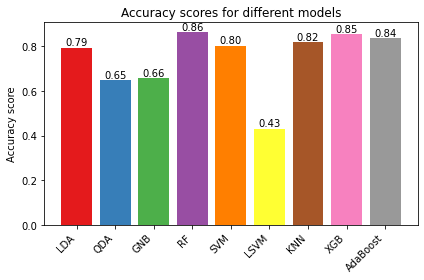

In [10]:
# Define models
models = [
    lda(),
    qda(),
    gnb(),
    rf(),
    svc(),
    lsvc(),
    knn(),
    xgb.XGBClassifier(max_depth=5, n_estimators=100, random_state=17),
    AdaBoostClassifier(n_estimators=100, random_state=17)
]

# Assign colors to models
colors = plt.cm.Set1(np.linspace(0, 1, len(models)))

accuracies = []
for model in models:
    clf = model.fit(X_train, y_train)
    a = accuracy_score(y_test, clf.predict(X_test))
    accuracies.append(a)

# Plot accuracy scores as a bar chart
plt.bar(range(len(models)), accuracies, color=colors)
plt.xticks(range(len(models)), ['LDA', 'QDA', 'GNB', 'RF', 'SVM', 'LSVM', 'KNN', 'XGB', 'AdaBoost'], rotation=45, ha="right")
plt.ylabel('Accuracy score')
plt.title('Accuracy scores for different models')

# Label each bar with the corresponding accuracy score
for i, acc in enumerate(accuracies):
    plt.text(i, acc, f'{acc:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


#### Rough look:
We pick random forest, ada boosting, XG boosting to look for further results. 

### Random Forest

Mean accuracy score:  0.7970029741477924 at depth:  1
Mean auc score:  0.5 at depth:  1
Mean accuracy score:  0.798089681994967 at depth:  3
Mean auc score:  0.5104912280701754 at depth:  3
Mean accuracy score:  0.8012926103866391 at depth:  5
Mean auc score:  0.5360431484115694 at depth:  5
Mean accuracy score:  0.8130633722260352 at depth:  10
Mean auc score:  0.5787358937885254 at depth:  10
Mean accuracy score:  0.8045756119881033 at depth:  20
Mean auc score:  0.5694727358937886 at depth:  20
Mean accuracy score:  0.8056508808053078 at depth:  30
Mean auc score:  0.5701394025604551 at depth:  30


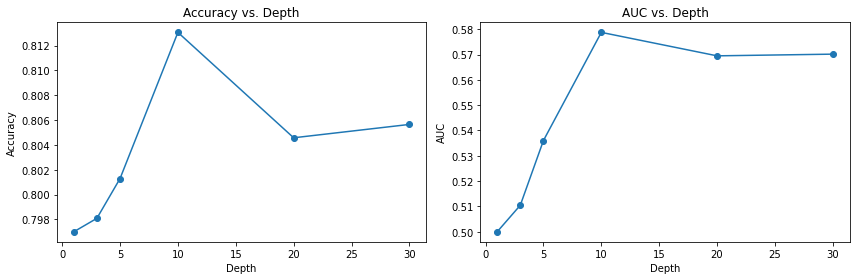

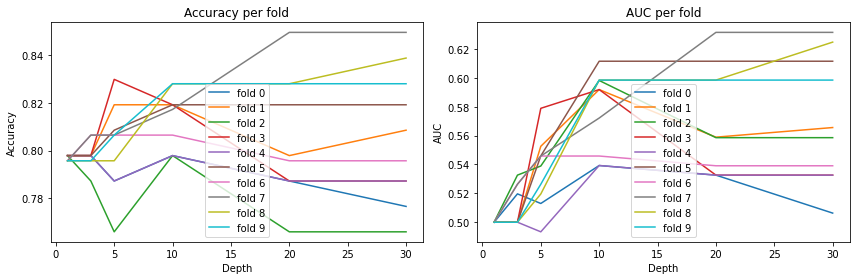

Best AUC occurs at index: 3 with depth: 10 and AUC: 0.5787358937885254


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold

depth = [1, 3, 5, 10, 20, 30]
n_splits = 10
ACC = []
AUC = []
ACC_fold = np.zeros((n_splits, len(depth)))
AUC_fold = np.zeros((n_splits, len(depth)))

for i in range(len(depth)):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    rfc = RandomForestClassifier(n_estimators=100, random_state=20, max_depth=depth[i])
    Acc = []
    Auc = []
    for j, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
        X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

        rfc.fit(X_fold_train, y_fold_train)
        y_pred = rfc.predict(X_fold_test)
        auc = roc_auc_score(y_fold_test, y_pred)
        acc = accuracy_score(y_fold_test, y_pred)
        ACC_fold[j, i] = acc
        AUC_fold[j, i] = auc
        Acc.append(acc)
        Auc.append(auc)

    ACC.append(sum(Acc) / n_splits)
    AUC.append(sum(Auc) / n_splits)
    print("Mean accuracy score: ", ACC[i], "at depth: ", depth[i])
    print("Mean auc score: ", AUC[i], "at depth: ", depth[i])

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(depth, ACC, marker='o')
axs[0].set_xlabel('Depth')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Accuracy vs. Depth')

axs[1].plot(depth, AUC, marker='o')
axs[1].set_xlabel('Depth')
axs[1].set_ylabel('AUC')
axs[1].set_title('AUC vs. Depth')

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for i in range(n_splits):
    axs[0].plot(depth, ACC_fold[i, :], label=f'fold {i}')
    axs[1].plot(depth, AUC_fold[i, :], label=f'fold {i}')

axs[0].set_xlabel('Depth')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Accuracy per fold')
axs[0].legend()

axs[1].set_xlabel('Depth')
axs[1].set_ylabel('AUC')
axs[1].set_title('AUC per fold')
axs[1].legend()

plt.tight_layout()
plt.show()

best_auc_index = np.argmax(AUC)
print("Best AUC occurs at index:", best_auc_index, "with depth:", depth[best_auc_index], "and AUC:", AUC[best_auc_index])


In [12]:
# Random Forest 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
depth = [1,3,5,10,20,30]
def testRandomForest(X_train, y_train, X_test, y_test):
    SEN = []
    SPC = []
    ACC = []
    AUC = []
    for i in range(len(depth)):
        model = RandomForestClassifier(n_estimators=100, random_state=17,max_depth=depth[i])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)
        # append
        ACC.append(acc)
        AUC.append(auc)
        SEN.append(sensitivity)
        SPC.append(specificity)
    return ACC,AUC,SEN,SPC 

In [13]:
acc, auc, sen, spc = testRandomForest(X_train, y_train, X_test, y_test)
print(depth)
print(sen)
print(spc)

[1, 3, 5, 10, 20, 30]
[0.0, 0.08695652173913043, 0.21739130434782608, 0.30434782608695654, 0.391304347826087, 0.391304347826087]
[1.0, 1.0, 0.978494623655914, 0.978494623655914, 0.967741935483871, 0.967741935483871]


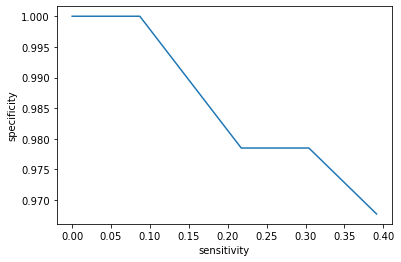

In [14]:
# sensitivity vs. specificity
plt.plot(sen,spc)
plt.xlabel('sensitivity')
plt.ylabel('specificity')
plt.show()

0.853448275862069


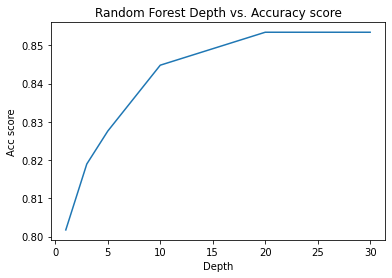

In [15]:
# check test accuracy 
print(max(acc))
plt.plot(depth,acc)
plt.xlabel('Depth')
plt.ylabel('Acc score')
plt.title('Random Forest Depth vs. Accuracy score')
plt.show()

0.679523141654979


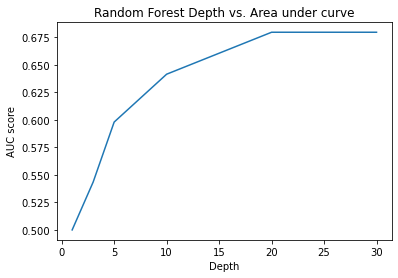

In [16]:
# check auc score
print(max(auc))
plt.plot(depth,auc)
plt.xlabel('Depth')
plt.ylabel('AUC score')
plt.title('Random Forest Depth vs. Area under curve')
plt.show()

### Check ROC and Confusion Matrix

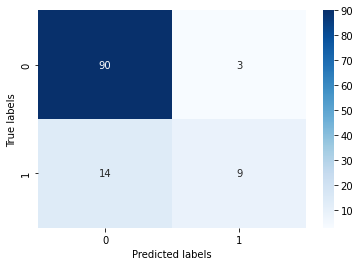

In [17]:
# train best parameter generated by k-fold
model = RandomForestClassifier(n_estimators=100, random_state=17,max_depth=30)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [18]:
def plot_roc_curve(y_pred, y_test):
    fpr, tpr, _ = roc_curve(y_pred, y_test)
    roc_auc = roc_auc_score(y_pred, y_test)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

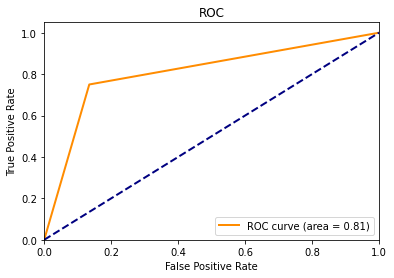

In [19]:
plot_roc_curve(y_pred, y_test)

### XG bossting and K-fold 

Mean accuracy score:  0.8013841226264014 at depth:  1
Mean auc score:  0.6007861545756282 at depth:  1
Mean accuracy score:  0.8173644474948525 at depth:  3
Mean auc score:  0.6441536273115219 at depth:  3
Mean accuracy score:  0.8152596659803247 at depth:  5
Mean auc score:  0.6291109530583215 at depth:  5
Mean accuracy score:  0.8270075497597803 at depth:  10
Mean auc score:  0.6443399715504978 at depth:  10
Mean accuracy score:  0.813097689315946 at depth:  20
Mean auc score:  0.6395490753911807 at depth:  20
Mean accuracy score:  0.813097689315946 at depth:  30
Mean auc score:  0.6395490753911807 at depth:  30


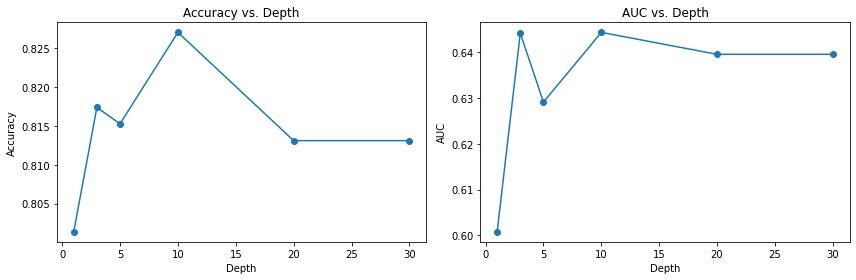

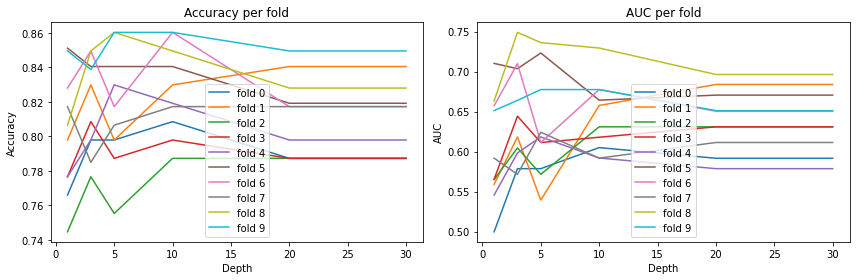

Best AUC occurs at index: 3 with depth: 10 and AUC: 0.6443399715504978


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold

depth = [1, 3, 5, 10, 20, 30]
n_splits = 10
ACC = []
AUC = []
ACC_fold = np.zeros((n_splits, len(depth)))
AUC_fold = np.zeros((n_splits, len(depth)))

for i in range(len(depth)):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    xgb_clf = xgb.XGBClassifier(n_estimators=100, random_state=20, max_depth=depth[i])
    Acc = []
    Auc = []
    for j, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
        X_fold_train, X_fold_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

        xgb_clf.fit(X_fold_train, y_fold_train)
        y_pred = xgb_clf.predict(X_fold_test)
        auc = roc_auc_score(y_fold_test, y_pred)
        acc = accuracy_score(y_fold_test, y_pred)
        ACC_fold[j, i] = acc
        AUC_fold[j, i] = auc
        Acc.append(acc)
        Auc.append(auc)

    ACC.append(sum(Acc) / n_splits)
    AUC.append(sum(Auc) / n_splits)
    print("Mean accuracy score: ", ACC[i], "at depth: ", depth[i])
    print("Mean auc score: ", AUC[i], "at depth: ", depth[i])

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(depth, ACC, marker='o')
axs[0].set_xlabel('Depth')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Accuracy vs. Depth')

axs[1].plot(depth, AUC, marker='o')
axs[1].set_xlabel('Depth')
axs[1].set_ylabel('AUC')
axs[1].set_title('AUC vs. Depth')

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for i in range(n_splits):
    axs[0].plot(depth, ACC_fold[i, :], label=f'fold {i}')
    axs[1].plot(depth, AUC_fold[i, :], label=f'fold {i}')

axs[0].set_xlabel('Depth')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Accuracy per fold')
axs[0].legend()

axs[1].set_xlabel('Depth')
axs[1].set_ylabel('AUC')
axs[1].set_title('AUC per fold')
axs[1].legend()

plt.tight_layout()
plt.show()

best_auc_index = np.argmax(AUC)
print("Best AUC occurs at index:", best_auc_index, "with depth:", depth[best_auc_index], "and AUC:", AUC[best_auc_index])


In [21]:
# XG boosting and just check AUC score
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

depth = [1,3,5,10,20,30]

def testXGBoost(X_train, y_train, X_test, y_test):
    SEN = []
    SPC = []
    ACC = []
    AUC = []
    for i in range(len(depth)):
        model = xgb.XGBClassifier(n_estimators=100, random_state=17, max_depth=depth[i])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)
        # append
        ACC.append(acc)
        AUC.append(auc)
        SEN.append(sensitivity)
        SPC.append(specificity)
    return ACC, AUC, SEN, SPC

acc,auc,sen,spc = testXGBoost(X_train, y_train, X_test, y_test)

[0.391304347826087, 0.34782608695652173, 0.43478260869565216, 0.4782608695652174, 0.43478260869565216, 0.43478260869565216]
[0.967741935483871, 0.946236559139785, 0.956989247311828, 0.946236559139785, 0.946236559139785, 0.946236559139785]


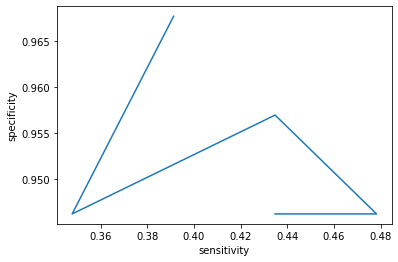

In [22]:
# sensitivity vs. specificity
print(sen)
print(spc)
plt.plot(sen,spc)
plt.xlabel('sensitivity')
plt.ylabel('specificity')
plt.show()

0.7122487143525011


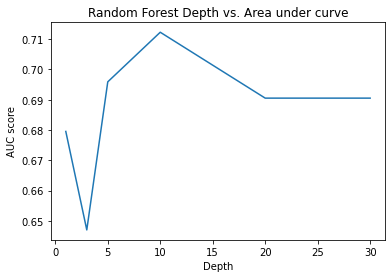

In [23]:
# check auc score
print(max(auc))
plt.plot(depth,auc)
plt.xlabel('Depth')
plt.ylabel('AUC score')
plt.title('Random Forest Depth vs. Area under curve')
plt.show()

0.853448275862069


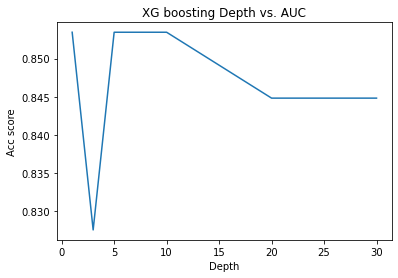

In [24]:
# check test accuracy 
print(max(acc))
plt.plot(depth,acc)
plt.xlabel('Depth')
plt.ylabel('Acc score')
plt.title('XG boosting Depth vs. AUC')
plt.show()

### ROC and confusion matrix for XG

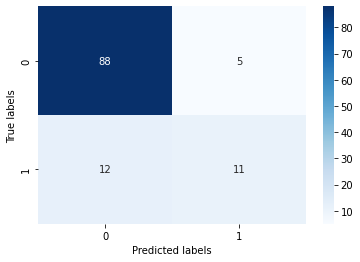

In [25]:
# train best parameter generated by k-fold
model = xgb.XGBClassifier(n_estimators=100, random_state=17, max_depth=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

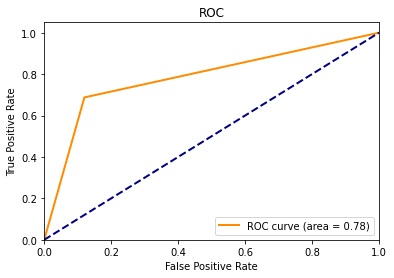

In [26]:
plot_roc_curve(y_pred, y_test)

### Adaboosting 

In [27]:
# ada boosting
def testAda(X_train, y_train, X_test, y_test):
    AUC = []
    SEN = []
    SPC = []
   
    model = AdaBoostClassifier(n_estimators=100, random_state=17)
    model.fit(X_train, y_train)
    
    y_scores = model.predict_proba(X_test)[:,1]
    y_pred = (y_scores > 0.4944444).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    acc = accuracy_score(y_pred,y_test)
    auc = roc_auc_score(y_pred,y_test)
    return acc,auc,sensitivity,specificity
acc,auc,sen,spc = testAda(X_train, y_train, X_test, y_test)
print("Accuracy:",acc)
print("AUC:", auc)
print("Sensitivity:", sen)
print("Specificity:", spc)

Accuracy: 0.7758620689655172
AUC: 0.67907995618839
Sensitivity: 0.6521739130434783
Specificity: 0.8064516129032258


### ROC and confusion matrix for ADA boosting

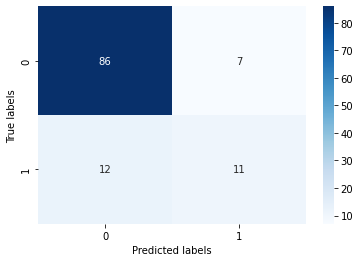

In [28]:
# train best parameter generated by k-fold
model = AdaBoostClassifier(n_estimators=100, random_state=17)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

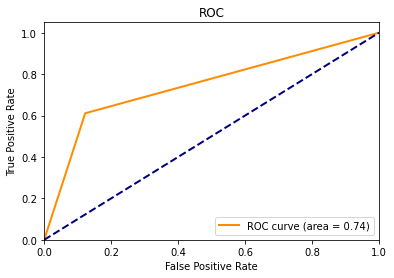

In [29]:
plot_roc_curve(y_pred, y_test)

### Voting Classifier

In [43]:
# voting classifier
# create the base models
rf = RandomForestClassifier(max_depth=10, random_state=17)
xgb_model = xgb.XGBClassifier(max_depth=10, n_estimators=100, random_state=17)
ada = AdaBoostClassifier(n_estimators=100, random_state=17)

# create the voting classifier
voting = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb_model), ('ada', ada)], voting='soft')

# fit the voting classifier to the training data
voting.fit(X_train, y_train)

# make predictions on the test data
y_pred_proba = voting.predict_proba(X_test)[:, 1]

# compute the evaluation metrics
auc = roc_auc_score(y_test, y_pred_proba)
y_pred = [1 if prob >= 0.26 else 0 for prob in y_pred_proba]
acc = accuracy_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# print the evaluation metrics
print("AUC score: ", auc)
print("Accuracy score: ", acc)
print("Sensitivity: ", sensitivity)
print("Specificity: ", specificity)



AUC score:  0.8803179055633473
Accuracy score:  0.8275862068965517
Sensitivity:  0.8695652173913043
Specificity:  0.8172043010752689


### ROC and AUC score for Voting

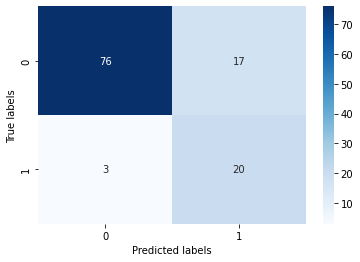

In [44]:
# train best parameter generated by k-fold
rf = RandomForestClassifier(max_depth=10, random_state=17)
xgb_model = xgb.XGBClassifier(max_depth=10, n_estimators=100, random_state=17)
ada = AdaBoostClassifier(n_estimators=100, random_state=17)

voting = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb_model), ('ada', ada)], voting='soft')
voting.fit(X_train, y_train)
y_pred_proba = voting.predict_proba(X_test)[:, 1]
y_pred = [1 if prob >= 0.26 else 0 for prob in y_pred_proba]

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

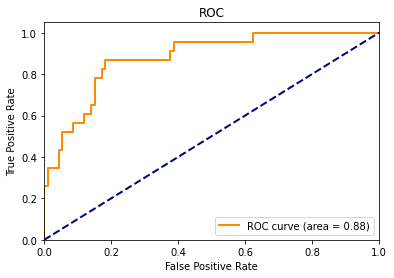

In [40]:
def plot_roc_curve(y_test, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()
plot_roc_curve(y_test, y_pred_proba)

### Choose best threshold for voting

In [41]:
# voting
# create the base models
rf = RandomForestClassifier(max_depth=10, random_state=17)
xgb_model = xgb.XGBClassifier(max_depth=10, n_estimators=100, random_state=17)
ada = AdaBoostClassifier(n_estimators=100, random_state=17)

# create the voting classifier
voting = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb_model), ('ada', ada)], voting='soft')

# fit the voting classifier to the training data
voting.fit(X_train, y_train)

# make predictions on the test data
y_pred_proba = voting.predict_proba(X_test)[:, 1]

# optimize the threshold for y_pred using a custom score function
best_threshold = None
best_score = None
for threshold in np.arange(0, 1.01, 0.01):
    y_pred = [1 if prob >= threshold else 0 for prob in y_pred_proba]
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    score = 1*sensitivity + specificity
    if best_score is None or score > best_score:
        best_score = score
        best_threshold = threshold

# compute the evaluation metrics using the optimized threshold
y_pred = [1 if prob >= best_threshold else 0 for prob in y_pred_proba]
auc = roc_auc_score(y_test, y_pred_proba)
acc = accuracy_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# print the evaluation metrics
print("AUC score: ", auc)
print("Accuracy score: ", acc)
print("Sensitivity: ", sensitivity)
print("Specificity: ", specificity)
print("Optimized threshold: ", best_threshold)


AUC score:  0.8803179055633473
Accuracy score:  0.8275862068965517
Sensitivity:  0.8695652173913043
Specificity:  0.8172043010752689
Optimized threshold:  0.26


In [42]:
best_threshold

0.26

### Test test set on Voting Algorithm

In [45]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# create the base models
rf = RandomForestClassifier(max_depth=10, random_state=17)
xgb_model = xgb.XGBClassifier(max_depth=10, n_estimators=100, random_state=17)
ada = AdaBoostClassifier(n_estimators=100, random_state=17)

# create the voting classifier
voting = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb_model), ('ada', ada)], voting='soft')

# fit the voting classifier to the training data
voting.fit(X_train, y_train)

# make predictions on the test data
y_pred_proba = voting.predict_proba(X_dev)[:, 1]

# compute the evaluation metrics
auc = roc_auc_score(y_dev, y_pred_proba)
y_pred = [1 if prob >= 0.26 else 0 for prob in y_pred_proba]
acc = accuracy_score(y_dev, y_pred)
tn, fp, fn, tp = confusion_matrix(y_dev, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# print the evaluation metrics
print("AUC score: ", auc)
print("Accuracy score: ", acc)
print("Sensitivity: ", sensitivity)
print("Specificity: ", specificity)



AUC score:  0.8165957446808512
Accuracy score:  0.7899159663865546
Sensitivity:  0.8
Specificity:  0.7872340425531915


### Check ROC and Confusion Matrix for Voting on Dev set

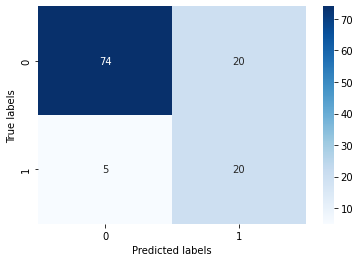

In [48]:
# train best parameter generated by k-fold
rf = RandomForestClassifier(max_depth=10, random_state=17)
xgb_model = xgb.XGBClassifier(max_depth=10, n_estimators=100, random_state=17)
ada = AdaBoostClassifier(n_estimators=100, random_state=17)

voting = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb_model), ('ada', ada)], voting='soft')
voting.fit(X_train, y_train)
y_pred_proba = voting.predict_proba(X_dev)[:, 1]
y_pred = [1 if prob >= 0.26 else 0 for prob in y_pred_proba]

# Compute confusion matrix
cm = confusion_matrix(y_dev, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

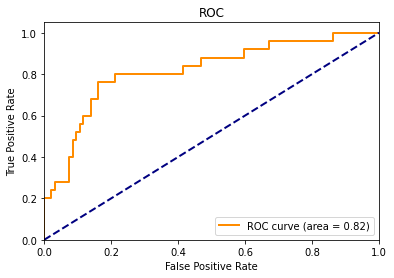

In [49]:
plot_roc_curve(y_dev, y_pred_proba)

### other stuff